<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/img_processing/stop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case study to find STOP signals in images

In this tutorial we develop a naiv algorithm to solve a specific task of computer/robot vision field. Our aim to find STOP traffic signals in digital images.

Planned steps

*   Filter red parts (keep only the pixels with different shades of red from the image)
*   Find contours (extract the contours of red areas)
*   Select octogon shape contours


In [ ]:
from math import sqrt
import numpy as np
import skimage
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull

First we download an image from the Internet with stop signal and we display it.

RGB image is stored as a 3D matrix (164, 245, 3) of integer values between (0, 255).
Red:   0 - 255
Green: 0 - 219
Blue:  0 - 238


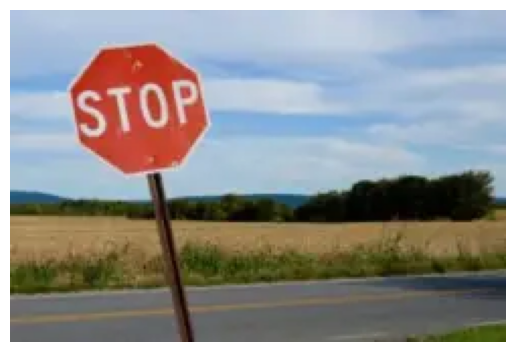

In [114]:
img  = skimage.io.imread('https://cdn.powa.com/baderscott.com/images/wp-content/uploads/2020/06/atlanta-ga-car-accident-lawyer-running-a-stop-signal-300x200-245-critical-desktop.jpg.webp')
#img = skimage.io.imread('https://i0.wp.com/the-peak.ca/wp-content/uploads/2023/10/wgog2-scaled.jpg?fit=2560%2C1779&ssl=1')
# remove noise
#img = skimage.filters.gaussian(orig_img, 1)    # it may help
#img = orig_img
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')
print(f"RGB image is stored as a 3D matrix {img.shape} of integer values between (0, 255).")
print(f"Red:   {np.min(img[:,:,0])} - {np.max(img[:,:,0])}")
print(f"Green: {np.min(img[:,:,1])} - {np.max(img[:,:,1])}")
print(f"Blue:  {np.min(img[:,:,2])} - {np.max(img[:,:,2])}")

In the RGB color space we cannot separate many shades of red or other colors. So we convert the RGB image to HSV space to separate different shades of red. Skimage scale HSV values to (0,1) interval.

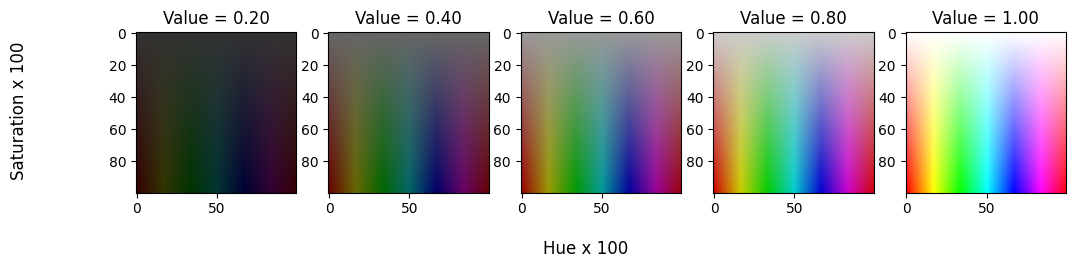

In [98]:
isize = 100
h_scale = np.zeros((isize, isize, 3), dtype=img_hsv.dtype)
h = np.arange(0.0, 1.0, 1 / h_scale.shape[1])
for i in range(isize):
        h_scale[i,:,0] = h
        h_scale[:,i,1] = h
icols = 5
fig, ax = plt.subplots(ncols=icols, figsize=(12, 3))
fig.supxlabel('Hue x 100')
fig.supylabel('Saturation x 100')
for i in range(icols):
    v = i / icols + 0.20
    h_scale[:,:,2] = v
    ax[i].imshow(skimage.color.hsv2rgb(h_scale))
    ax[i].set_title(f'Value = {v:.2f}')

From the images above we can realize the *hue* should be greater than 0.6 and the *saturation* should be less than 0.1 for red color. We can also limit the *value* to be larger 0.3 to avoid very dark shades.

The four steps of the processing


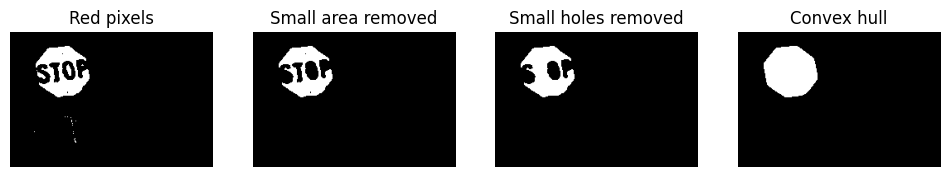

In [115]:
img_hsv = skimage.color.rgb2hsv(img)
total_area = img.shape[0] * img.shape[1]
#img_bin = ((img_hsv[:,:,1] > 0.6) & (img_hsv[:,:,0] < 0.1) & (img_hsv[:,:,2] > 0.3) | # red pixels
#            ((img_hsv[:,:,0] < 0.2) | (img_hsv[:,:,0] > 0.8)) & (img_hsv[:,:,1] < 0.3) & (img_hsv[:,:,2] > 0.8)) # white pixels
#img1_bin = (img_hsv[:,:,1] > 0.6) & (img_hsv[:,:,0] < 0.1) & (img_hsv[:,:,2] > 0.3) # red pixels
img1_bin = ((img_hsv[:,:,0] < 0.1) | (img_hsv[:,:,0] > 0.8)) & (img_hsv[:,:,1] > 0.6) & (img_hsv[:,:,2] > 0.3) # red pixels
fig, ax = plt.subplots(ncols=4, figsize=(12, 3))
ax[0].set_title('Red pixels')
ax[0].imshow(img1_bin, cmap='gray')
ax[0].axis('off')
img2_bin = skimage.morphology.remove_small_objects(img1_bin, 0.005*total_area)
ax[1].set_title('Small area removed')
ax[1].imshow(img2_bin, cmap='gray')
ax[1].axis('off')
img3_bin = skimage.morphology.remove_small_holes(img2_bin, 0.005*total_area)
ax[2].set_title('Small holes removed')
ax[2].imshow(img3_bin, cmap='gray')
ax[2].axis('off')
img4_bin = skimage.morphology.convex_hull_image(img3_bin) # not useful if more signals are in the same image
ax[3].set_title('Convex hull')
ax[3].imshow(img4_bin, cmap='gray')
ax[3].axis('off')
print("The four steps of the processing")

In the black and white images above the the red pixels are white and all the others are black.

The convex hull in the raster is not working if more then one large red block is available in the raster (e.g. two stop signal). So we continue with *img_bin3*, where small areas and holes are removed.

We will generate polygons from the white areas of the third raster image and postpone the convex hull generation to the vector polygons.

8
Stop signal at 63.8, 48.1
4


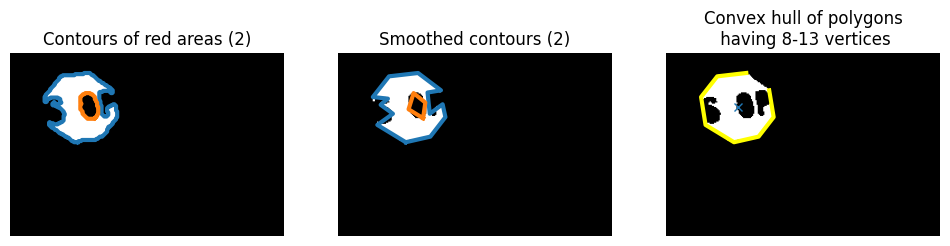

In [116]:
cnts = skimage.measure.find_contours(img3_bin)
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
for i in range(3):
    ax[i].imshow(img3_bin, cmap='gray')
ax[0].set_title(f"Contours of red areas ({len(cnts)})")
ax[0].axis('off')
ax[1].set_title(f"Smoothed contours ({len(cnts)})")
ax[1].axis('off')
ax[2].set_title("Convex hull of polygons\n having 8-13 vertices")
ax[2].axis('off')
for contour in cnts:
    ax[0].plot(contour[:,1], contour[:,0], linewidth=3)
    appr = skimage.measure.approximate_polygon(contour, tolerance=5.0)
    ax[1].plot(appr[:,1], appr[:, 0], linewidth=3)
    hull = ConvexHull(appr)
    x = [appr[i,1] for i in hull.vertices]
    y = [appr[i,0] for i in hull.vertices]
    n = len(x)
    print(n)
    if 7 < n < 15:
        ax[2].plot(x, y, c='yellow', linewidth=3)
        center = sum(x) / n, sum(y) / n
        ax[2].plot(center[0], center[1], 'x', linewidth=3)
        print(f"Stop signal at {center[0]:.1f}, {center[1]:.1f}")

In [113]:
type(img.shape)

tuple

Finaly test our algorithm with different images.
For this let's create a compact function for the simplicity.

Here we add a new condition for the area of the polygon comparing the total area of the image, to eliminate small area from the result.


In [117]:
def area(poly):
    """ calculate area of the polygon given as numpy array or list
    """
    coords = np.array(poly)
    coords1 = np.vstack((coords, coords[0]))    # first point to last
    return abs(np.sum((coords1[:-1, 0] - coords1[1:, 0]) * (coords1[:-1, 1] + coords1[1:, 1]))) / 2

def perimeter(poly):
    """ calculate perimeter of polygon given as numpy array or list
    """
    coords = np.array(poly)
    coords1 = np.vstack((coords, coords[0]))    # first point to last
    return np.sum(np.sqrt(np.sum(np.square(np.diff(coords1, axis=0)), axis=1)))

def stop_signs(img, area_limit=0.005):
    """ find stop traffic signal in image
        returns a list with the positions of the possible stop traffic signals and the convex hull of them
    """
    total_area = img.shape[0] * img.shape[1]
    img_hsv = skimage.color.rgb2hsv(img)
    img_bin = ((img_hsv[:,:,0] < 0.1) | (img_hsv[:,:,0] > 0.8)) & (img_hsv[:,:,1] > 0.6) & (img_hsv[:,:,2] > 0.3) # red pixels
    img_bin = skimage.morphology.remove_small_objects(img_bin, area_limit*total_area)
    img_bin = skimage.morphology.remove_small_holes(img_bin, area_limit*total_area)
    cnts = skimage.measure.find_contours(img_bin)
    res = []
    resp = []
    for contour in cnts:
        appr = skimage.measure.approximate_polygon(contour, tolerance=area_limit*max(img.shape))  # smooth border
        try:
            hull = ConvexHull(appr)
        except:
            continue
        if 6 < hull.vertices.shape[0] < 14:
            xy = appr[hull.vertices]
            contour_area = area(xy)
            contour_peri = perimeter(xy)
            a_p = sqrt(contour_area) / contour_peri     # shape parameter
            if contour_area / total_area > area_limit or \
               0.26 < a_p < 0.30: #    # skip small or narrow areas
                res.append(np.mean(xy, axis=0))    # weight point of poly
                resp.append(xy)
    return res, resp


# Testing

First test the function with the image we used sofar.

In [124]:
stop_signs(img)[0]

[array([53.13636364, 61.09090909]), array([46.9375, 70.6875])]

We collected few images from the Internet for testing.

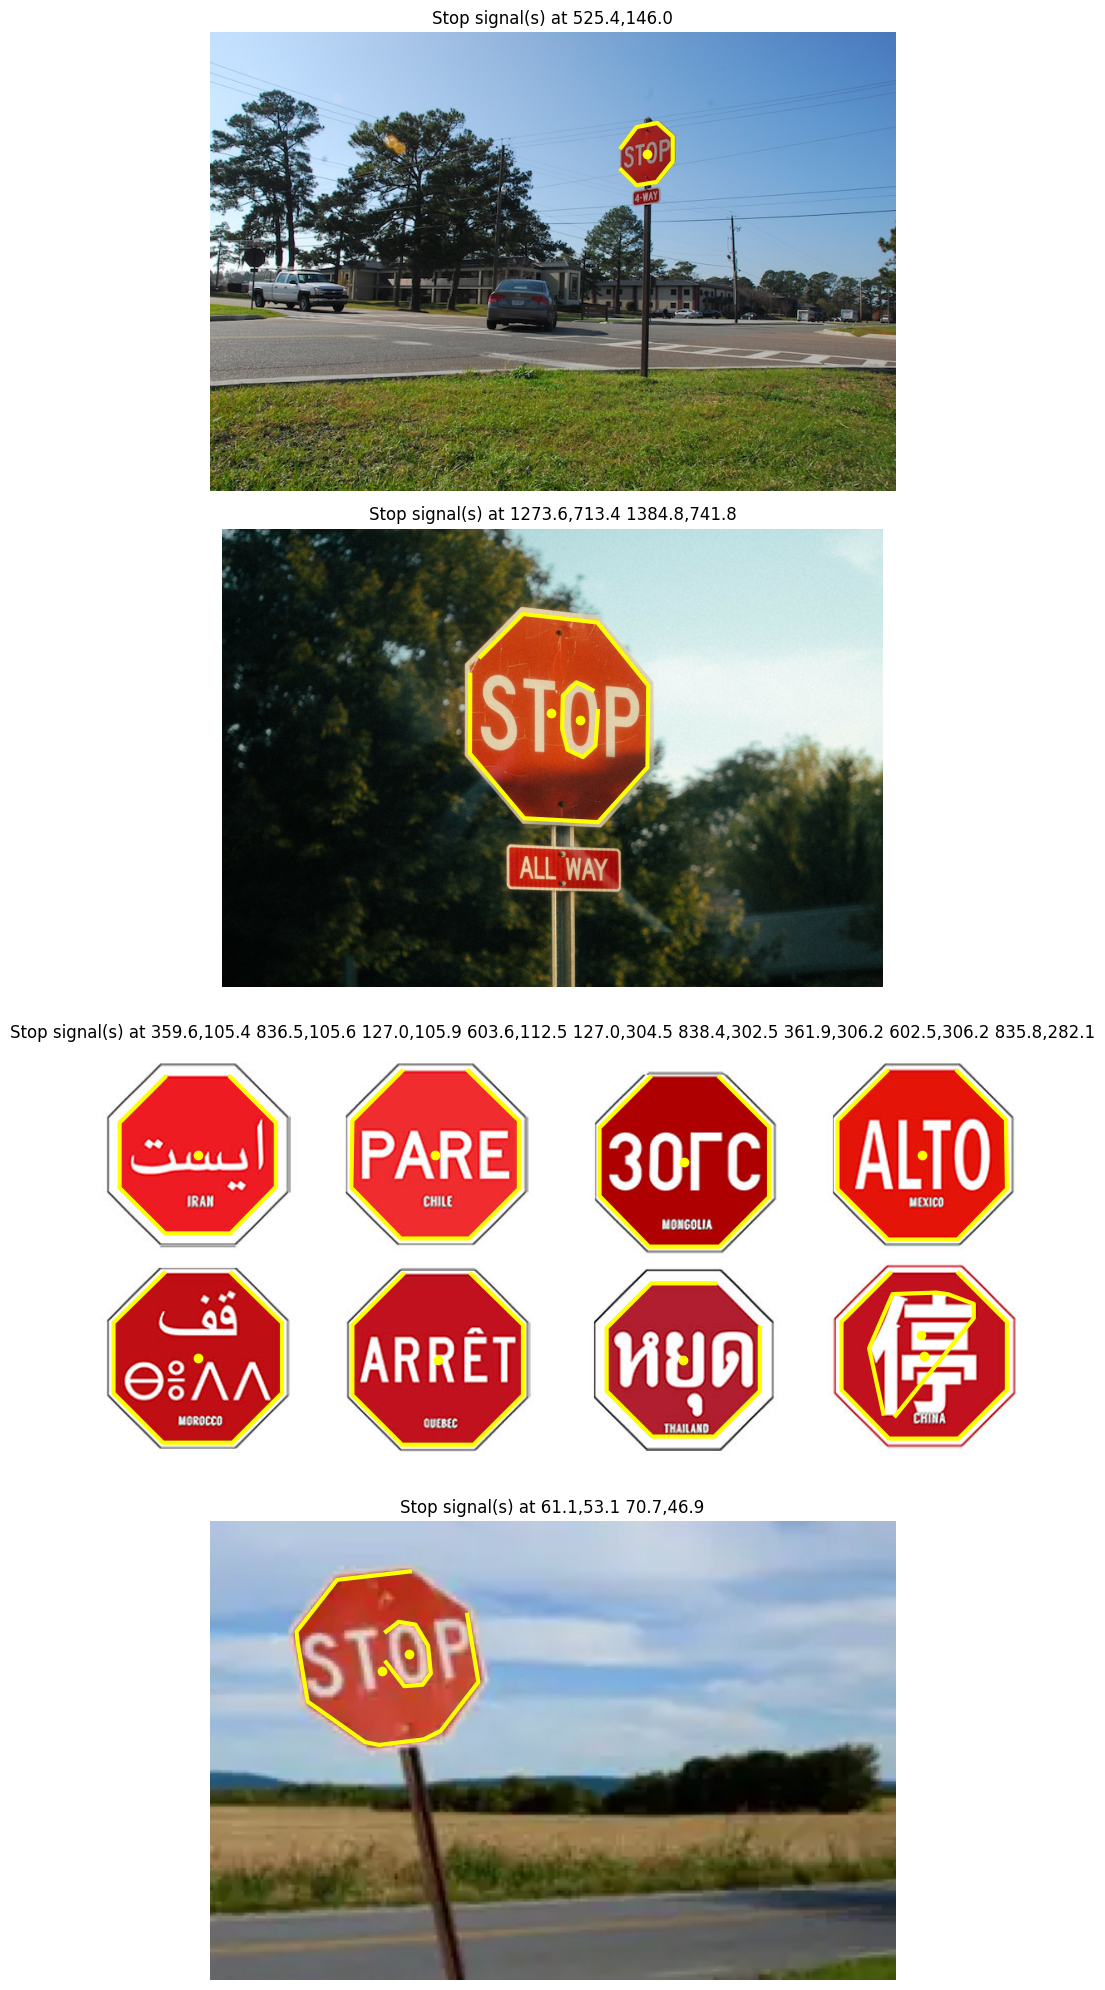

In [125]:
img_paths = ['https://media.defense.gov/2009/Dec/08/2000417879/825/780/0/091207-F-5660L-009.JPG',
            'https://i0.wp.com/the-peak.ca/wp-content/uploads/2023/10/wgog2-scaled.jpg?fit=2560%2C1779&ssl=1',
            'https://www.frontsigns.com/wp-content/uploads/2018/06/Stop-traffic-signs.jpg',
             'https://cdn.powa.com/baderscott.com/images/wp-content/uploads/2020/06/atlanta-ga-car-accident-lawyer-running-a-stop-signal-300x200-245-critical-desktop.jpg.webp']
fig, ax = plt.subplots(nrows=len(img_paths), figsize=(10, 20))
for i, img_path in enumerate(img_paths):
    im = skimage.io.imread(img_path)
    ax[i].imshow(im)
    ax[i].axis('off')
    signs, polys = stop_signs(im)
    s = np.array(signs)
    ax[i].plot(s[:,1], s[:,0], 'o', c="yellow")
    title = "Stop signal(s) at"
    for sign in signs:
        title += f" {sign[1]:.1f},{sign[0]:.1f}"
    for poly in polys:
        ax[i].plot(poly[:,1], poly[:,0], c="yellow", linewidth=3)
    ax[i].set_title(title)
plt.tight_layout(w_pad=3)

From these tests we can realize our algoritm is not perfect.

#Tasks

1. Make more tests using new images!

2. Try to improve the algorithm, not to find letter "O" inside the stop mark!

2. Make a better algorithm!




# Closing thoughts

Traffict signal recognition is an important part of the self-driving vehicles researches. It is mostly solved for several different traffic signs using convolutional neural networks with supervised machine learning. In this case the separation of the sign from the image is also done by similiar image processing methods we used before.